# Surface Defect Detection with pretrained networks

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import copy
import os
import PIL
%matplotlib inline
plt.ion()

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [2]:
baseDirectory = 'g:/Selim/Thesis/Code/PyTorch/'
setDirectory = '3MAll'
setImageSize = 224

# 3MAll set mean and std values
# mean : 0.498283411655
# std : 0.0879390792679
setMean = [0.498, 0.498, 0.498]
setStd = [0.087, 0.087, 0.087]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [72]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )

{'train': 8950, 'test': 632} images will be used.
GPU will be used.


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

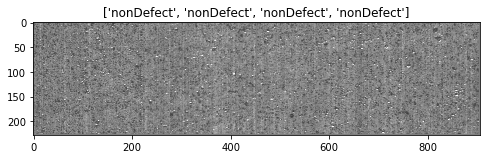

In [73]:
def ImShow(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    input = setStd * input + setMean
    plt.figure(figsize=(8,8))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
ImShow(out, title=[datasetClasses[x] for x in classes])

### 2.3.2 VisualizeModel (in progress!)

This function helps displaying the predictions of the network.

In [75]:
def VisualizeModel(model, numImages=6):
    imagesSoFar = 0
    fig = plt.figure()
    
    for i, data in enumerate(datasetLoaders['test']):
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            imagesSoFar += 1
            ax = plt.subplot(numImages // 2, 2, imagesSoFar)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(datasetClasses[labels.data[j]]))
            ImShow(inputs.cpu().data[j])
            
            if imagesSoFar == numImages:
                return

## 2.4 Training functions

This section contains functions used in training the network.

### 2.4.1 TrainModelMiniBatch

Here we have 2 different training functions. First one uses mini batches and a separate learning-rate scheduler function for training.

In [76]:
def TrainModelMiniBatch(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in datasetLoaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if useGPU:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

### 2.4.2 TrainModelBatch

This is the previous method of training which uses all of the images in the training set for each training iteration.

In [77]:
def TrainModelBatch(model, criterion, optimizer, lrDecay, maxIteration):
    currentIteration = 0
    startTime = time.time()
    trainSetSize = datasetSizes['train']
    
    shuffledIndices = torch.randperm(trainSetSize)
    print('Started training...')
    
    while True:
        runningLoss = 0
        for iInput, data in enumerate(datasetLoaders['train'], 0):
            inputs, labels = data
            if useGPU:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print(iInput)
            runningLoss += loss.data[0]
            
        currentError = runningLoss / trainSetSize
        print('Iteration: ' + str(currentIteration) + '# current error = ' + str(currentError))
        currentIteration += 1
        
        if maxIteration > 0 and currentIteration > maxIteration:
            print('# Maximum iteration reached. End of training.')
            print('# Training error = ' + str(currentError))
            timeElapsed = time.time() - startTime            
            print('Training complete in {:.0f}m {:.0f}s'.format(timeElapsed // 60, timeElapsed % 60))
            break


### 2.4.3 ExpLRScheduler

Updates the learning-rate after each `lr_decay_epoch` number of epochs.

In [78]:
def ExpLRScheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer

## 2.5 Loading pretrained networks

### 2.5.1 ResNet18
PyTorch has the ResNet18 network which was pretrained on ImageNet.

In [79]:
modelRN18 = models.resnet18(pretrained=True)

# Get input size of the fully-connected layer
numFeatures = modelRN18.fc.in_features

# Change last, fully-connected layer for our 2-class output.
modelRN18.fc = nn.Linear(numFeatures, 2)

if useGPU:
    modelRN18 = modelRN18.cuda()

print(modelRN18)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

### 2.5.2 Inception v3
Here similarly we load the Inception v3 by Google. Inception requires images with different sizes so it will be evaulated later.

In [81]:
modelIv3 = models.inception_v3(pretrained=True)

# Get input size of the fully-connected layer
numFeatures = modelIv3.fc.in_features

# Change last, fully-connected layer for our 2-class output.
modelIv3.fc = nn.Linear(numFeatures, 2)

if useGPU:
    modelIv3 = modelIv3.cuda()

print(modelIv3)

Inception3 (
  (Conv2d_1a_3x3): BasicConv2d (
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d (
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d (
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d (
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d (
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA (
    (branch1x1): BasicConv2d (
      (conv): Conv2d(192, 64, kernel_

### 2.5.3 AlexNet
Lastly the AlexNet...

In [82]:
modelAN = models.alexnet(pretrained=True)

# Get output size of the fully-connected layer
numFeatures = modelAN.classifier[6].out_features

# Add one last, fully-connected layer for our 2-class output.
modelAN.add_module('fc', nn.Linear(numFeatures, 2))

if useGPU:
    modelAN = modelAN.cuda()

print(modelAN)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
  (fc): Linear (1000 -> 2)
)


### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [84]:
criterion = nn.CrossEntropyLoss()

if useGPU:
    criterion = criterion.cuda()

optimizerRN18 = optim.SGD(modelRN18.parameters(), lr=0.001, momentum=0.9)
optimizerIv3 = optim.SGD(modelIv3.parameters(), lr=0.001, momentum=0.9)
optimizerAN = optim.SGD(modelAN.parameters(), lr=0.001, momentum=0.9)

## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

In [ ]:
TrainModelMiniBatch(modelRN18, criterion, optimizerRN18, ExpLRScheduler, num_epochs=3)

In [26]:
#TrainModelMiniBatch(modelIv3, criterion, optimizerRN18, ExpLRScheduler, num_epochs=3)

In [ ]:
TrainModelMiniBatch(modelAN, criterion, optimizerRN18, ExpLRScheduler, num_epochs=3)

In [85]:
# Batch training compared to mini-batch
#TrainModelBatch(modelRN18, criterion, optimizer, 0, maxIteration=3)

Some example weight visualization:

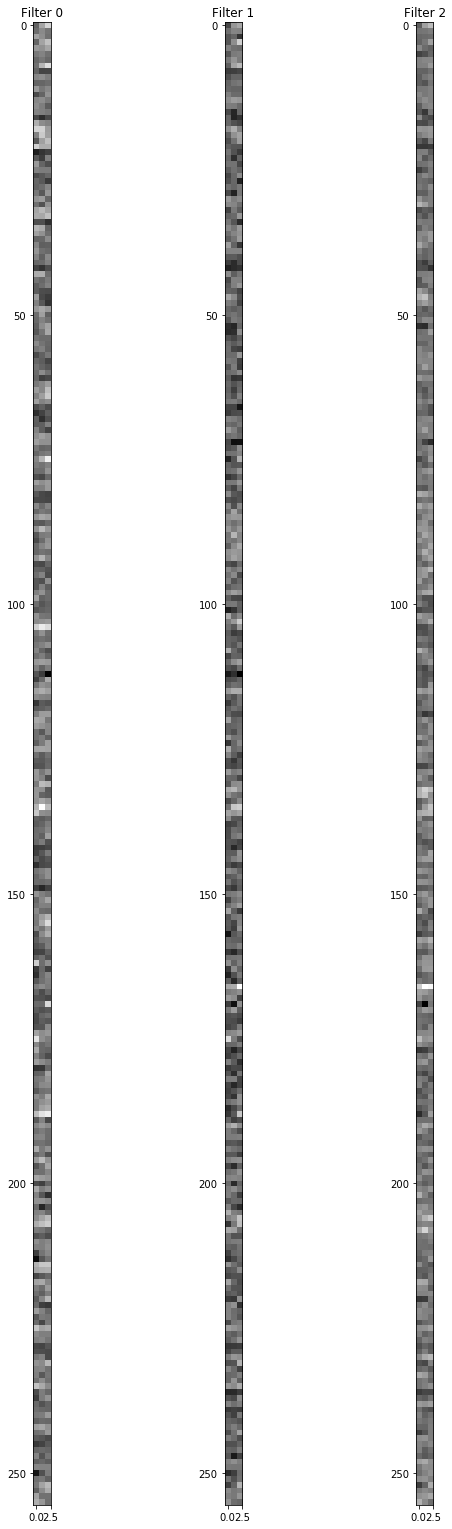

In [57]:
import math
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,60))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
plotNNFilter(modelRN18.layer4[0].conv1.weight.cpu().data.numpy())